## Installation

In [ ]:
import tensorflow as tf

if tf.config.list_physical_devices('GPU'):
    print("GPU is available")
else:
    print("GPU is not available")

In [ ]:
!pip install tensorflow==2.15

In [ ]:
!pip install keras==2.15.0

In [2]:
import tensorflow as tf
print(tf.__version__)

2.15.0


In [1]:
import keras
print(keras.__version__)


2024-08-08 05:40:36.759325: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-08 05:40:36.759376: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-08 05:40:36.760750: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


2.15.0


In [3]:
!pip install tensorflow-addons

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 11.0 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: typeguard
    Found existing installation: typeguard 4.1.5
    Uninstalling typeguard-4.1.5:
      Successfully uninstalled typeguard-4.1.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ydata-profiling 4.6.4 requires numpy<1.26,>=1.16.0, but you have numpy 1.26.4 which is incompatible.
ydata-profiling 4.6.4 requires typeguard<5,>=4.1.2, but you have typeguard 2.13.3 which is incompatible.


In [4]:
# import system lib
import os
import time
import shutil
import pathlib
import itertools

# import data handling tools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers
import tensorflow_addons as tfa
from keras import backend as K
# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

modules loaded


/opt/conda/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


## Input

In [5]:
!kaggle datasets download -d shadmansobhan/tb-detection-4-august

Dataset URL: https://www.kaggle.com/datasets/shadmansobhan/tb-detection-4-august
License(s): MIT
 99%|███████████████████████████████████████▊| 505M/508M [00:05<00:00, 92.5MB/s]
100%|████████████████████████████████████████| 508M/508M [00:05<00:00, 93.2MB/s]


In [6]:
import zipfile
import os

# Path to the zip file
zip_file_path = '/kaggle/working/tb-detection-4-august.zip'

# Path to the directory where the zip file will be extracted
extract_to_path = '/kaggle/working/Image Files'

# Extract the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to_path)

print(f"Extracted {zip_file_path} to {extract_to_path}")


Extracted /kaggle/working/tb-detection-4-august.zip to /kaggle/working/Image Files


# Preprocessing

### histogram & Clahe

In [7]:
import cv2
import os

# Define the folder path containing the images
folder_path = '/kaggle/working/Image Files/S+M_Custom'

# Initialize a counter for the total number of preprocessed images
preprocessed_count = 0

# Recursively traverse the directory tree
for root, _, files in os.walk(folder_path):
    for file in files:
        image_path = os.path.join(root, file)

        # Only process files with valid image extensions
        if file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
            image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

            # Check if the image was successfully loaded
            if image is None:
                print(f"Image at path '{image_path}' not found.")
                continue

            # Apply CLAHE (Contrast Limited Adaptive Histogram Equalization)
            clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
            clahe_image = clahe.apply(image)

            # Apply histogram equalization on the original image (not on CLAHE result)
            hist_eq_image = cv2.equalizeHist(image)

            # Apply CLAHE and then histogram equalization
            hist_eq_then_clahe_image = clahe.apply(hist_eq_image)

            # Save the modified image, replacing the original
            cv2.imwrite(image_path, hist_eq_then_clahe_image)

            # Increment the counter
            preprocessed_count += 1

            #print(f"Processed and replaced image at path '{image_path}'")

# Print the total number of preprocessed images
print(f"Total number of images preprocessed: {preprocessed_count}")



Total number of images preprocessed: 800


# **CSV FIle Generation based on Labelled Image**

In [8]:
data_dir = "/kaggle/working/Image Files/S+M_Custom"
filepaths = []
labels = []

folds = os.listdir(data_dir)
for fold in folds:
    foldpath = os.path.join(data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        filepaths.append(fpath)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
df = pd.concat([Fseries, Lseries], axis= 1)

In [9]:
df

,filepaths,labels
0,/kaggle/working/Image Files/S+M_Custom/Tubercu...,Tuberculosis
1,/kaggle/working/Image Files/S+M_Custom/Tubercu...,Tuberculosis
2,/kaggle/working/Image Files/S+M_Custom/Tubercu...,Tuberculosis
3,/kaggle/working/Image Files/S+M_Custom/Tubercu...,Tuberculosis
4,/kaggle/working/Image Files/S+M_Custom/Tubercu...,Tuberculosis
...,...,...
795,/kaggle/working/Image Files/S+M_Custom/Normal/...,Normal
796,/kaggle/working/Image Files/S+M_Custom/Normal/...,Normal
797,/kaggle/working/Image Files/S+M_Custom/Normal/...,Normal
798,/kaggle/working/Image Files/S+M_Custom/Normal/...,Normal


In [10]:
print("Unique labels in the DataFrame:")
print(df['labels'].unique())

Unique labels in the DataFrame:
['Tuberculosis' 'Normal']


# Splitting data for training

In [11]:
# train dataframe
train_df, test_df = train_test_split(df,  train_size= 0.8, shuffle= True, random_state= 1)

# valid and test dataframe
# valid_df, test_df = train_test_split(dummy_df,  train_size= 0.5, shuffle= True, random_state= 123)

class_counts_train = train_df['labels'].value_counts()

# Print the counts for each class in the training set
print("Class counts in training set:")
print(class_counts_train)

Class counts in training set:
labels
Normal          321
Tuberculosis    319
Name: count, dtype: int64


In [12]:
import cv2

def tf_equalize_histogram(image):
    values_range = tf.constant([0., 255.], dtype=tf.float32)

    # Convert image to float32 using tf.cast
    image_float = tf.cast(image, dtype=tf.float32)

    histogram = tf.histogram_fixed_width(image_float, values_range, 256)
    cdf = tf.cumsum(histogram)
    cdf_min = cdf[tf.reduce_min(tf.where(tf.greater(cdf, 0)))]

    img_shape = tf.shape(image)
    pix_cnt = img_shape[-3] * img_shape[-2]
    px_map = tf.round(tf.cast(cdf - cdf_min, dtype=tf.float32) * 255. / tf.cast(pix_cnt - 1, dtype=tf.float32))

    px_map = tf.cast(px_map, dtype=tf.uint8)

    # Use tf.gather to map values from px_map to the image
    eq_hist_img = tf.gather(px_map, tf.cast(image_float, dtype=tf.int32))

    return eq_hist_img

def preprocess_image(img):
    # img = img / 255.0
    img = tfa.image.equalize(img)
    img = tf.image.adjust_contrast(img, contrast_factor=1.2)

    # Normalize the image to the range [0, 1]
    # img = img / 255.0

    # Clip values to ensure they are in the valid range [0, 1]
    # img = tf.clip_by_value(img, 0.0, 1.0)

    # Convert the image to float32 if needed

    img = tf.cast(img, dtype=tf.float32)

    return img

# cropped image size
batch_size = 16
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

# Recommended : use custom function for test data batch size, else we can use normal batch size.
ts_length = len(test_df)
test_batch_size = 8
#max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

# This function which will be used in image data generator for data augmentation, it just take the image and return it again.
def scalar(img):
    return img

tr_gen = ImageDataGenerator(
        # featurewise_center=True,
        # featurewise_std_normalization= True,
        horizontal_flip=False,  # Set to True for random horizontal flips
        vertical_flip=False,  # Set to False to disable vertical flips
        rotation_range=12,
        zoom_range=0.2,
        preprocessing_function = scalar
        )

ts_gen = ImageDataGenerator(preprocessing_function= scalar)

train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

# valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
#                                     color_mode= 'rgb', shuffle= True, batch_size= batch_size)

# Note: we will use custom test_batch_size, and make shuffle= false
test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= test_batch_size)


Found 640 validated image filenames belonging to 2 classes.
Found 160 validated image filenames belonging to 2 classes.


**Sample from training data**

In [13]:
g_dict = train_gen.class_indices     # defines dictionary {'class': index}
classes = list(g_dict.keys())       # defines list of dictionary's keys (classes), classes names : string
images, labels = next(train_gen)      # get a batch size samples from the generator


print("Class indices dictionary:", g_dict)
print("List of class names:", classes)

Class indices dictionary: {'Normal': 0, 'Tuberculosis': 1}
List of class names: ['Normal', 'Tuberculosis']


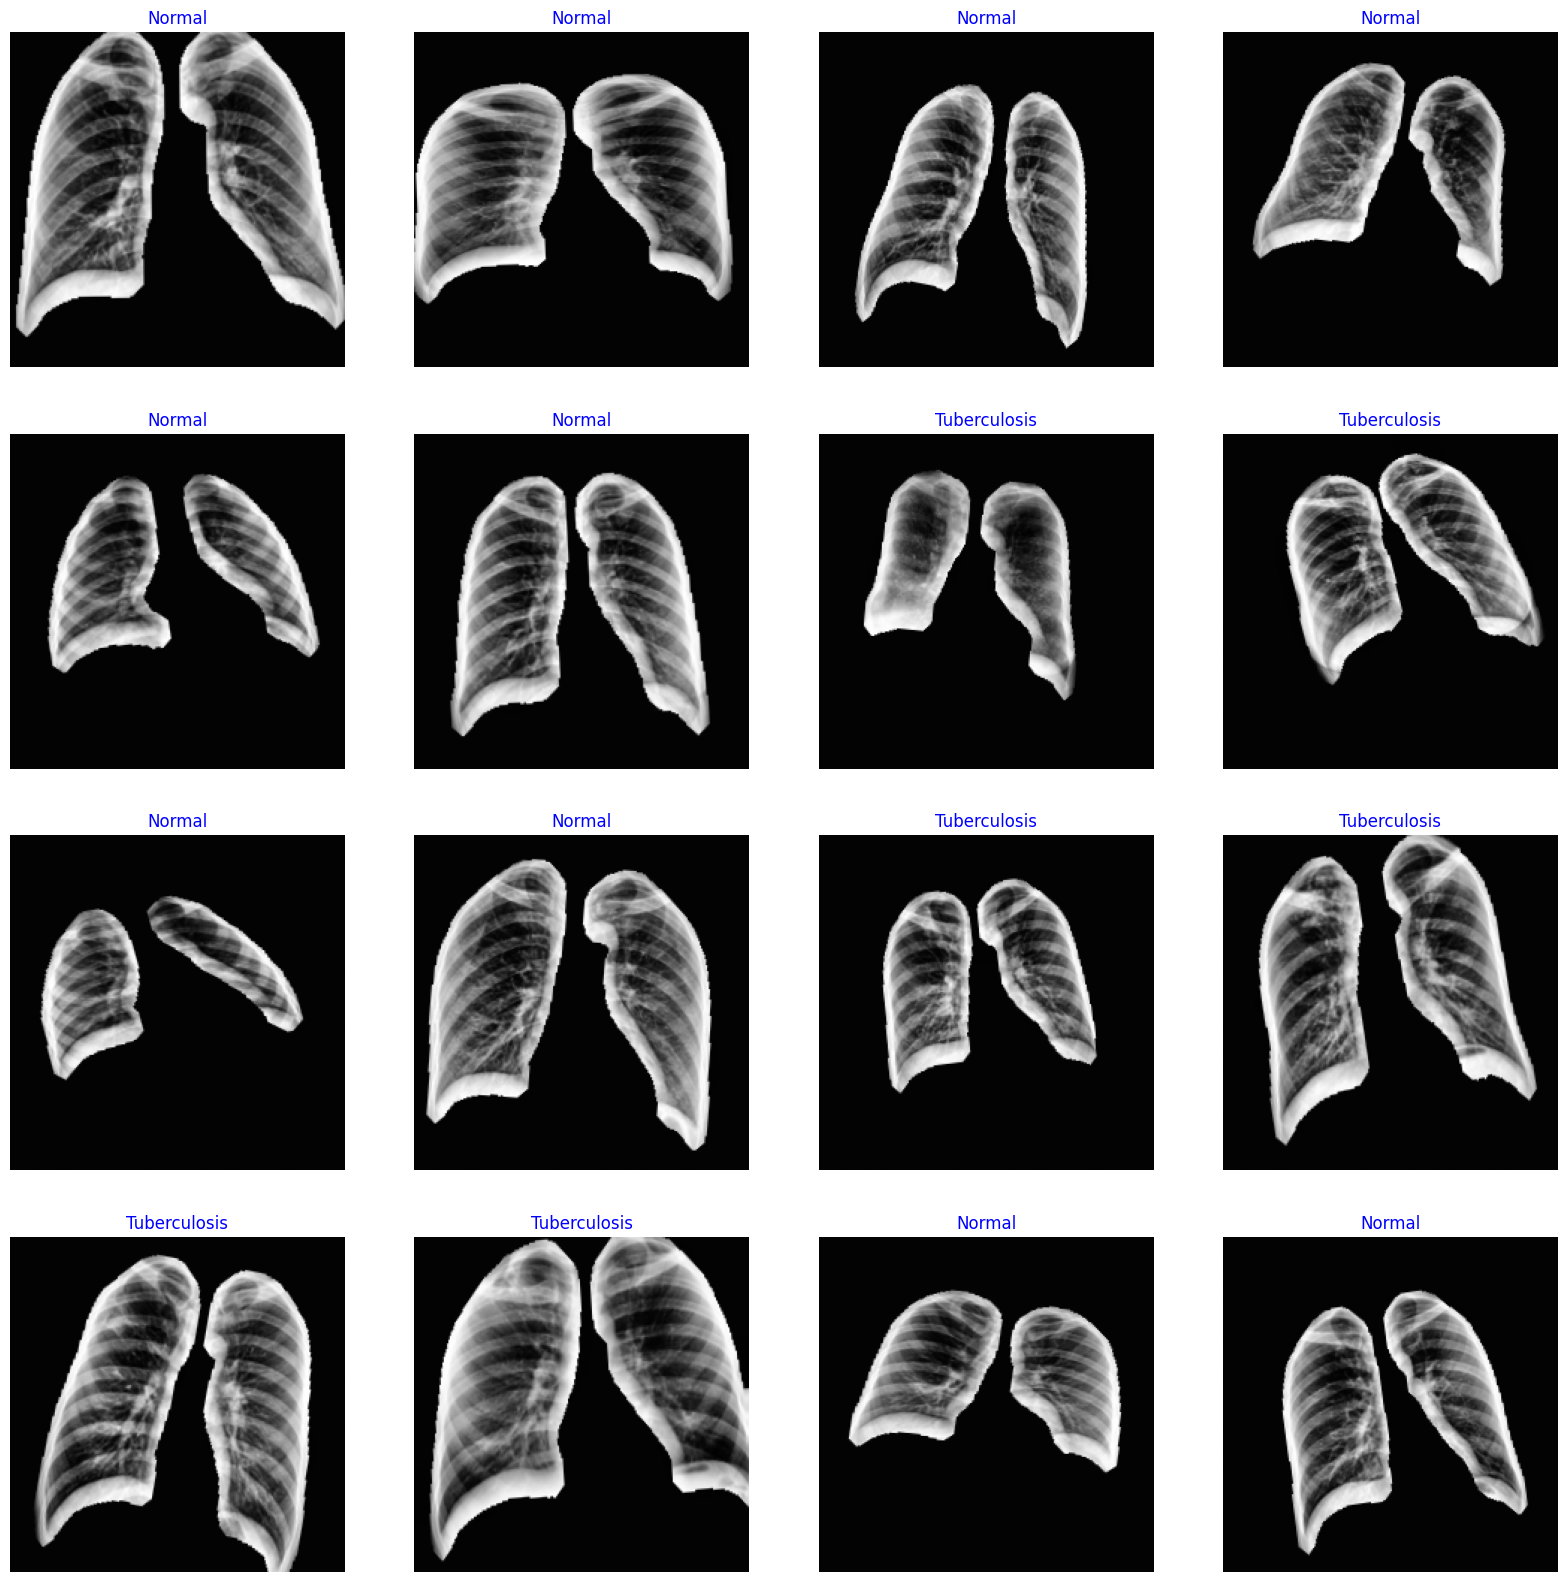

In [14]:
plt.figure(figsize= (20, 20))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255       # scales data to range (0 - 255)
    plt.imshow(image)
    index = np.argmax(labels[i])  # get image index
    class_name = classes[index]   # get class of image
    plt.title(class_name, color= 'blue', fontsize= 12)
    plt.axis('off')
plt.show()

In [15]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras import backend as K

# Example train_df for demonstration (replace with your actual data)
# train_df = pd.read_csv('your_data.csv')

# Get the value counts for the labels
label_counts = train_df['labels'].value_counts()

# Check the unique values in the labels
if len(label_counts) < 2:
    raise ValueError("There are not enough classes in the 'labels' column. Make sure there are at least two classes.")

# Extract the counts for each class
train_norm = label_counts.iloc[0]
train_tb = label_counts.iloc[1]

print('Percent of Tuberculosis/Normal : {} %'.format(100 * train_tb/train_norm))

# Create positive frequency and negative frequency
freq_pos = round((train_tb / train_norm), 2)
freq_neg = 1 - freq_pos

pos_weights = freq_neg
neg_weights = freq_pos
pos_contribution = freq_pos * pos_weights
neg_contribution = freq_neg * neg_weights

print(pos_contribution, neg_contribution)

# Create weighted loss function
def get_weighted_loss(pos_weights, neg_weights, epsilon=1e-7):
    def weighted_loss(y_true, y_pred):
        # Initialize loss to zero
        loss = 0.0
        # For each class, add average weighted loss for that class
        loss += K.mean(-(pos_weights * y_true * K.log(y_pred + epsilon) +
                         neg_weights * (1 - y_true) * K.log(1 - y_pred + epsilon)))
        return loss
    return weighted_loss

# Example usage of the weighted loss function
# model.compile(optimizer='adam', loss=get_weighted_loss(pos_weights, neg_weights))

Percent of Tuberculosis/Normal : 99.37694704049844 %
0.00990000000000001 0.00990000000000001


In [16]:
# strategy = tf.distribute.TPUStrategy(resolver)
train_norm = train_df['labels'].value_counts()[0]
train_tb = train_df['labels'].value_counts()[1]

print('Percent of Tuberculosis/Normal : {} %'.format(100 * train_tb/train_norm))

#create positive frequency and negative frequency
freq_pos = round((train_tb/train_norm),2)
freq_neg = 1 - freq_pos

pos_weights = freq_neg
neg_weights = freq_pos
pos_contribution = freq_pos * pos_weights
neg_contribution = freq_neg * neg_weights

print(pos_contribution, neg_contribution)

# create weight loss
def get_weighted_loss(pos_weights, neg_weights, epsilon=1e-7):

    def weighted_loss(y_true, y_pred):
        # initialize loss to zero
        loss = 0.0

        # for each class, add average weighted loss for that class
        loss += K.mean(-(pos_weights *y_true * K.log(y_pred + epsilon)
                             + neg_weights* (1 - y_true) * K.log( 1 - y_pred + epsilon)))
        return loss

    return weighted_loss

Percent of Tuberculosis/Normal : 99.37694704049844 %
0.00990000000000001 0.00990000000000001


# Model Creation

### Eff Net

16705208/16705208 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional  (None, 1280)              4049571   
 )                                                               
                                                                 
 batch_normalization (Batch  (None, 1280)              5120      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 256)               327936    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 2)                 514       
                                                         

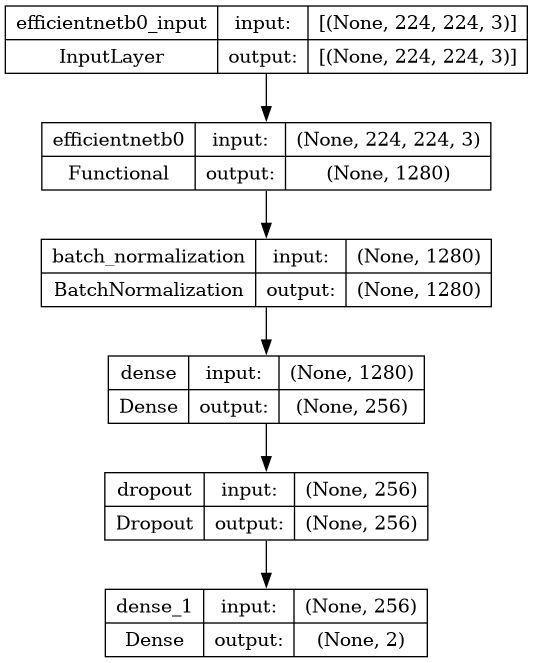

In [17]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.applications.efficientnet import preprocess_input

# Create Model Structure
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys())) # to define number of classes in dense layer


# create pre-trained model (you can built on pretrained model such as :  efficientnet, VGG , Resnet )
# we will use efficientnetb3 from EfficientNet family.
base_model = tf.keras.applications.efficientnet.EfficientNetB0(include_top= False, weights= "imagenet", input_shape= img_shape, pooling= 'max')
# base_model.trainable = False


model = Sequential([
        base_model,
        BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
        Dense(256, kernel_regularizer= regularizers.l2(l= 0.016), activity_regularizer= regularizers.l1(0.006),
                    bias_regularizer= regularizers.l1(0.006), activation= 'relu'),
        Dropout(rate= 0.45, seed= 123),
        Dense(class_count, activation= 'softmax')
])

class CustomModelCheckpoint(Callback):
    def __init__(self, filepath, monitor='val_accuracy', mode='max', verbose=1):
        super(CustomModelCheckpoint, self).__init__()
        self.filepath = filepath
        self.monitor = monitor
        self.verbose = verbose
        self.mode = mode
        self.best_val_acc = -np.Inf if mode == 'max' else np.Inf
        self.best_train_acc = -np.Inf

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        current_val_acc = logs.get(self.monitor)
        current_train_acc = logs.get('accuracy')

        if current_val_acc is None or current_train_acc is None:
            return

        # Check if current validation accuracy is the best seen so far
        if current_val_acc > self.best_val_acc:
            self.best_val_acc = current_val_acc
            self.best_train_acc = current_train_acc
            self.model.save_weights(self.filepath)
            if self.verbose > 0:
                print(f'\nEpoch {epoch + 1}: {self.monitor} improved to {current_val_acc}, saving model.')

        # If the validation accuracy is equal, check for higher training accuracy
        elif current_val_acc == self.best_val_acc and current_train_acc > self.best_train_acc:
            self.best_train_acc = current_train_acc
            self.model.save_weights(self.filepath)
            if self.verbose > 0:
                print(f'\nEpoch {epoch + 1}: {self.monitor} same as best, but training accuracy improved to {current_train_acc}, saving model.')

# Usage in model training
checkpoint = CustomModelCheckpoint(
    filepath='best_weights',
    monitor='val_accuracy',
    mode='max',
    verbose=1
)

early = EarlyStopping(monitor="val_loss",
                      mode="min",
                      patience=8)


model.compile(Adamax(learning_rate= 0.001), loss=get_weighted_loss(pos_weights, neg_weights) , metrics= ['accuracy'])

model.summary()

from tensorflow.keras.utils import plot_model

# Assuming 'model' is your defined model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
#'categorical_crossentropy'

In [18]:
def build_lrfn(lr_start=0.000001, lr_max=0.001,
               lr_min=0, lr_rampup_epochs=8,
               lr_sustain_epochs=0, lr_exp_decay=.8):

    def lrfn(epoch):
        if epoch < lr_rampup_epochs:
            lr = (lr_max - lr_start) / lr_rampup_epochs * epoch + lr_start
        elif epoch < lr_rampup_epochs + lr_sustain_epochs:
            lr = lr_max
        else:
            lr = (lr_max - lr_min) *\
                 lr_exp_decay**(epoch - lr_rampup_epochs\
                                - lr_sustain_epochs) + lr_min
        return lr
    return lrfn

lrfn = build_lrfn()
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=True)

# Training

In [ ]:
batch_size = 16   # set batch size for training
# epochs = 100   # number of all epochs in training


# history = model.fit( x=train_gen,
#                     epochs= epochs,
#                     verbose= 1,
#                     validation_data= valid_gen,
#                     validation_steps= None,
#                     callbacks=[lr_schedule, early, checkpoint],
#                     shuffle= False)

import numpy as np
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import load_model

history_data=[]

# Define the number of folds for cross-validation
num_folds = 5

# Initialize k-fold cross-validation
skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Initialize variables to store results
all_accuracies = []

# Perform k-fold cross-validation
fold_count = 0
for train_index, valid_index in skf.split(train_df, train_df['labels']):
    fold_count += 1
    print(f"\nTraining Fold {fold_count}")

    # Split data into training and validation sets
    train_fold, valid_fold = train_df.iloc[train_index], train_df.iloc[valid_index]

    # Data generators for this fold
    # train_gen = tr_gen.flow_from_dataframe(train_fold, x_col='filepaths', y_col='labels', target_size=img_size,
    #                                        class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batch_size)

    # valid_gen = ts_gen.flow_from_dataframe(valid_fold, x_col='filepaths', y_col='labels', target_size=img_size,
    #                                        class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=batch_size)
    train_gen = tr_gen.flow_from_dataframe( train_fold, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

    valid_gen = ts_gen.flow_from_dataframe( valid_fold, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

    # Load a new instance of the model for each fold


    # Train the model

    history = model.fit(x=train_gen, epochs=75, verbose=1, validation_data=valid_gen, validation_steps=None,
                        callbacks=[lr_schedule, early, checkpoint], shuffle=False)
    history_data.append(history)
    # Evaluate on the validation set of this fold

    valid_accuracy = model.evaluate(valid_gen)[1]
    all_accuracies.append(valid_accuracy)

# Calculate and print the average accuracy across all folds
average_accuracy = np.mean(all_accuracies)
print(f'\nAverage Accuracy across all Folds: {average_accuracy}')



# Weight Load

In [ ]:
#model.save_weights('/kaggle/input/weight-of-sm/tensorflow2/default/1')

In [19]:
model.load_weights("/kaggle/input/weight-of-sm/tensorflow2/default/1/sm.h5")
#model.load_weights('best_weights');

## Model Performance

In [ ]:
tr_acc=[]
tr_loss=[]
val_acc=[]
val_loss=[]
for history in history_data:
  n=len(history.history['accuracy'])
  for i in range(n):
    tr_acc.append(history.history['accuracy'][i])
    tr_loss.append(history.history['loss'][i])
    val_acc.append(history.history['val_accuracy'][i])
    val_loss.append(history.history['val_loss'][i])

index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()


**Evaluation**

In [ ]:
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

# Predictions

In [20]:
preds = model.predict_generator(test_gen)
y_pred = np.argmax(preds, axis=1)

**Report**

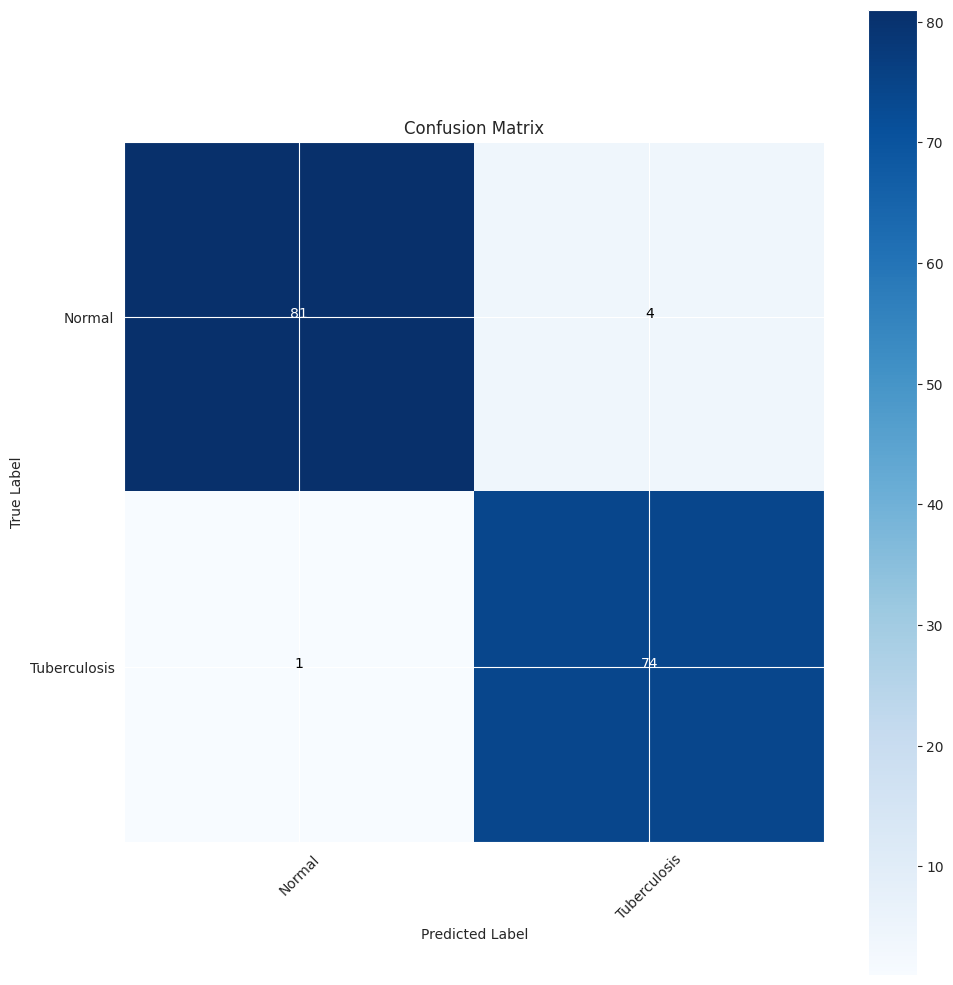

In [24]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

In [23]:
# Classification report
print(classification_report(test_gen.classes, y_pred, target_names= classes))

              precision    recall  f1-score   support

      Normal       0.99      0.95      0.97        85
Tuberculosis       0.95      0.99      0.97        75

    accuracy                           0.97       160
   macro avg       0.97      0.97      0.97       160
weighted avg       0.97      0.97      0.97       160



# XAI

In [25]:
!pip install lime
!pip install shap

# # # # 64

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 31ms/step


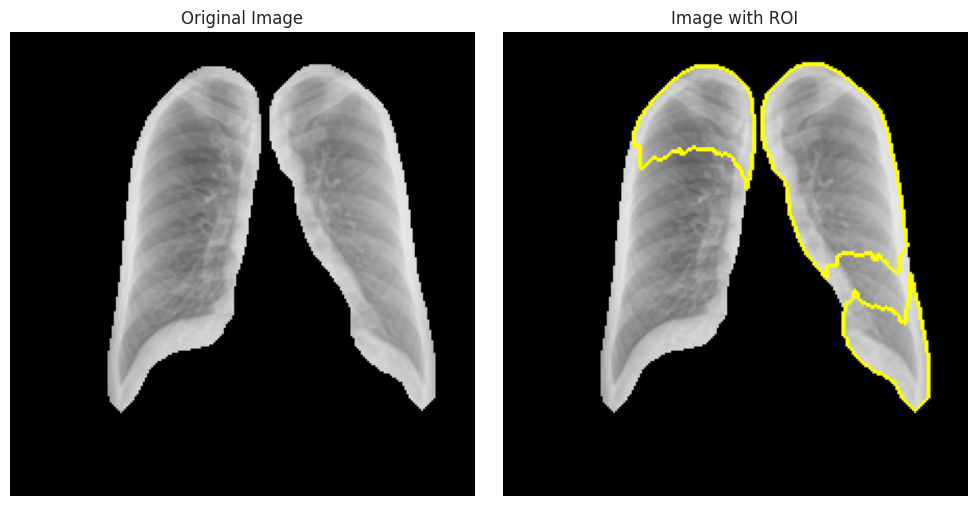

In [31]:
import matplotlib.pyplot as plt
import numpy as np
from lime import lime_image
from skimage.segmentation import mark_boundaries
from PIL import Image

# Initialize LIME image explainer
explainer = lime_image.LimeImageExplainer()

# Example preprocessing function (replace with your preprocessing logic)
def preprocess_image(img_path):
    # Load and preprocess your image (example assumes resizing to 224x224)
    img = Image.open(img_path)
    img = img.convert('RGB')  # Ensure RGB mode
    img = img.resize((224, 224))  # Resize to model input size
    img = np.array(img)  # Convert PIL image to numpy array
    return img

# Example prediction function (replace with your model prediction function)
def predict_fn(images):
    # Assuming 'model' is your trained Keras model
    return model.predict(images)

# Select an image to explain
img_path = '/kaggle/working/Image Files/Shenzhen_Custom_Masks/Normal/CHNCXR_0064_0.png'
img = preprocess_image(img_path)

# Ensure the image is in the correct shape for LIME
img = img.astype(np.float32) / 255.0  # Normalize to [0, 1] if needed

# Explain the prediction
explanation = explainer.explain_instance(
    image=img,
    classifier_fn=predict_fn,
    top_labels=1,
    hide_color=0,
    num_samples=1000
)

# Get the explanation for the top class
temp, mask = explanation.get_image_and_mask(
    label=explanation.top_labels[0],
    positive_only=False,
    num_features=5,
    hide_rest=False
)

# Overlay the explanation mask on the original image
img_with_mask = mark_boundaries(np.array(img), mask)

# Show the original image with overlaid ROI
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(np.array(img))
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(img_with_mask)
plt.title('Image with ROI')
plt.axis('off')

plt.tight_layout()
plt.show()


1/1 [==============================] - 0s 26ms/step
The predicted class is: Normal


  0%|          | 0/4998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.40s/it]               


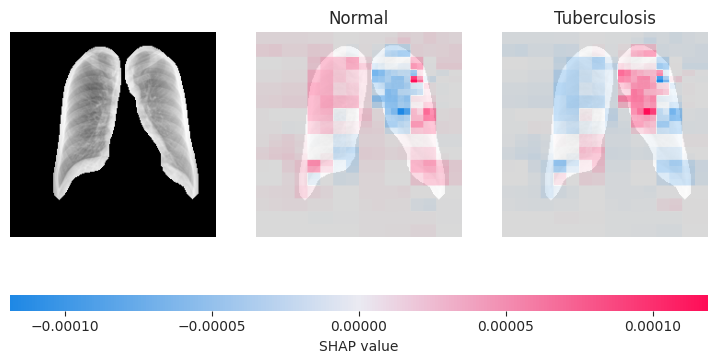

In [33]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np
import shap
import matplotlib.pyplot as plt

# Define the image size
img_size = (224, 224)  # Adjust this to match your model's input size

# Define the image path
img_path = '/kaggle/working/Image Files/Shenzhen_Custom_Masks/Normal/CHNCXR_0064_0.png'
#img_path="/content/Shenzhen/Normal/CHNCXR_0010_0.png"
#img_path="/content/Shenzhen/Normal/CHNCXR_0028_0.png"
#img_path="/content/Shenzhen/Tuberculosis/CHNCXR_0327_1.png"
#img_path="/content/Shenzhen/Tuberculosis/CHNCXR_0333_1.png"
#img_path="/content/Shenzhen/Tuberculosis/CHNCXR_0360_1.png"

# Load and preprocess the image
img = image.load_img(img_path, target_size=img_size)
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = tf.keras.applications.efficientnet.preprocess_input(img_array)

# Make a prediction
predictions = model.predict(img_array)

# Get the class with the highest probability
predicted_class = np.argmax(predictions, axis=1)

# Assuming you have a list of class names
class_names = list(train_gen.class_indices.keys())  # Ensure train_gen is defined
predicted_class_name = class_names[predicted_class[0]]

print(f'The predicted class is: {predicted_class_name}')

# Define the function for SHAP
def f(x):
    tmp = x.copy()
    return model(tmp)

# Create the masker using the shape of the loaded image
masker_blur = shap.maskers.Image("blur(224,224)", img_array.shape[1:])

# Create the explainer
explainer = shap.Explainer(f, masker_blur, output_names=class_names)

# Compute SHAP values
shap_values = explainer(img_array, max_evals=5000, batch_size=50)

# Normalize SHAP values to fall within the range [0, 1]
#shap_values.values = np.clip(shap_values.values, -1, 1)
#shap_values.values = (shap_values.values - shap_values.values.min()) / (shap_values.values.max() - shap_values.values.min())

# Normalize the image array to [0, 1] range for plotting
img_array_display = (img_array - img_array.min()) / (img_array.max() - img_array.min())

# Plot the SHAP values
shap.image_plot(shap_values, img_array_display, labels=class_names)


Last convolutional layer name: top_conv


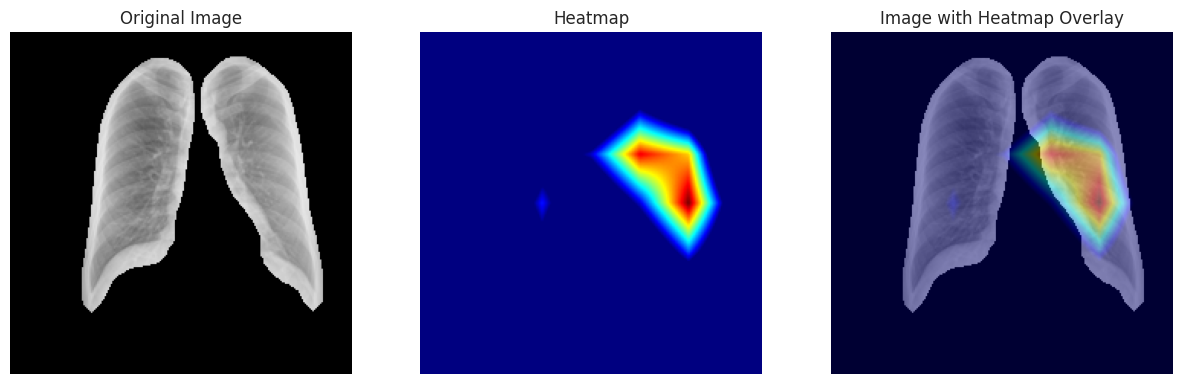

In [35]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.efficientnet import preprocess_input
import numpy as np
import cv2
import matplotlib.pyplot as plt

def make_gradcampp_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape1:
        with tf.GradientTape() as tape2:
            with tf.GradientTape() as tape3:
                last_conv_layer_output, preds = grad_model(img_array)
                if pred_index is None:
                    pred_index = tf.argmax(preds[0])
                class_channel = preds[:, pred_index]

            grads = tape3.gradient(class_channel, last_conv_layer_output)
        grads2 = tape2.gradient(class_channel, last_conv_layer_output)
    grads3 = tape1.gradient(class_channel, last_conv_layer_output)

    alpha_num = grads2**2
    alpha_denom = 2 * grads2**2 + tf.reduce_sum(last_conv_layer_output * grads3, axis=(1, 2))
    alpha_denom = tf.where(alpha_denom != 0, alpha_denom, tf.ones(alpha_denom.shape))
    alphas = alpha_num / alpha_denom
    weights = tf.reduce_sum(alphas * tf.maximum(grads, 0), axis=(1, 2))

    last_conv_layer_output = last_conv_layer_output[0]
    cam = tf.reduce_sum(weights[:, tf.newaxis, tf.newaxis] * last_conv_layer_output, axis=-1)

    heatmap = tf.maximum(cam, 0) / tf.math.reduce_max(cam)
    heatmap = tf.image.resize(heatmap[..., tf.newaxis], (img_array.shape[1], img_array.shape[2]))
    heatmap = tf.squeeze(heatmap)

    return heatmap.numpy()

def display_gradcam(img_path, heatmap, alpha=0.4, threshold_percentile=90):
    # Load and preprocess the original image
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Resize heatmap to match the original image size
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

    # Apply dynamic threshold to the heatmap based on percentile
    threshold_value = np.percentile(heatmap, threshold_percentile)
    heatmap = np.maximum(heatmap - threshold_value, 0)
    heatmap = heatmap / np.max(heatmap)  # Normalize the heatmap

    # Apply colormap to the heatmap
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)  # Convert heatmap to RGB for blending

    # Blend heatmap with the original image
    blended_img = (heatmap * alpha) + (img * (1 - alpha))
    blended_img = np.clip(blended_img, 0, 255).astype(np.uint8)

    # Plotting
    plt.figure(figsize=(15, 5))

    # Plot original image
    plt.subplot(1, 3, 1)
    plt.imshow(img)
    plt.title('Original Image')
    plt.axis('off')

    # Plot heatmap
    plt.subplot(1, 3, 2)
    plt.imshow(heatmap)
    plt.title('Heatmap')
    plt.axis('off')

    # Plot original image with heatmap overlay
    plt.subplot(1, 3, 3)
    plt.imshow(blended_img)
    plt.title('Image with Heatmap Overlay')
    plt.axis('off')

    plt.show()

def get_last_conv_layer_name(model):
    for layer in reversed(model.layers):
        if isinstance(layer, tf.keras.layers.Conv2D):
            return layer.name
    return None

# Example usage
img_path = '/kaggle/working/Image Files/Shenzhen_Custom_Masks/Normal/CHNCXR_0064_0.png'
#img_path="/content/Shenzhen/Normal/CHNCXR_0010_0.png"
#img_path="/content/Shenzhen/Normal/CHNCXR_0028_0.png"
#img_path="/content/Shenzhen/Tuberculosis/CHNCXR_0327_1.png"
#img_path="/content/Shenzhen/Tuberculosis/CHNCXR_0333_1.png"
#img_path = "/content/Shenzhen/Tuberculosis/CHNCXR_0360_1.png"
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

# Assuming 'base_model' is your model instance
last_conv_layer_name = get_last_conv_layer_name(base_model)
print("Last convolutional layer name:", last_conv_layer_name)

# Create the heatmap
heatmap = make_gradcampp_heatmap(x, base_model, last_conv_layer_name)

display_gradcam(img_path, heatmap)


# # # # 343

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 31ms/step


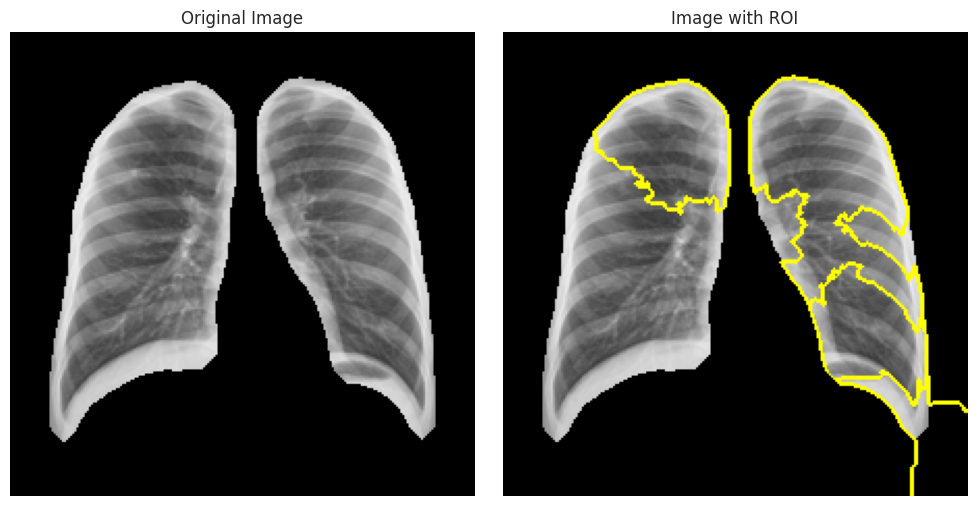

In [36]:
import matplotlib.pyplot as plt
import numpy as np
from lime import lime_image
from skimage.segmentation import mark_boundaries
from PIL import Image

# Initialize LIME image explainer
explainer = lime_image.LimeImageExplainer()

# Example preprocessing function (replace with your preprocessing logic)
def preprocess_image(img_path):
    # Load and preprocess your image (example assumes resizing to 224x224)
    img = Image.open(img_path)
    img = img.convert('RGB')  # Ensure RGB mode
    img = img.resize((224, 224))  # Resize to model input size
    img = np.array(img)  # Convert PIL image to numpy array
    return img

# Example prediction function (replace with your model prediction function)
def predict_fn(images):
    # Assuming 'model' is your trained Keras model
    return model.predict(images)

# Select an image to explain
img_path = '/kaggle/working/Image Files/Shenzhen_Custom_Masks/Tuberculosis/CHNCXR_0343_1.png'
#img_path="/content/Shenzhen/Normal/CHNCXR_0010_0.png"
#img_path="/content/Shenzhen/Normal/CHNCXR_0028_0.png"
#img_path="/content/Shenzhen/Tuberculosis/CHNCXR_0327_1.png"
#img_path="/content/Shenzhen/Tuberculosis/CHNCXR_0333_1.png"
#img_path="/content/Shenzhen/Tuberculosis/CHNCXR_0360_1.png"
img = preprocess_image(img_path)

# Ensure the image is in the correct shape for LIME
img = img.astype(np.float32) / 255.0  # Normalize to [0, 1] if needed

# Explain the prediction
explanation = explainer.explain_instance(
    image=img,
    classifier_fn=predict_fn,
    top_labels=1,
    hide_color=0,
    num_samples=1000
)

# Get the explanation for the top class
temp, mask = explanation.get_image_and_mask(
    label=explanation.top_labels[0],
    positive_only=False,
    num_features=5,
    hide_rest=False
)

# Overlay the explanation mask on the original image
img_with_mask = mark_boundaries(np.array(img), mask)

# Show the original image with overlaid ROI
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(np.array(img))
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(img_with_mask)
plt.title('Image with ROI')
plt.axis('off')

plt.tight_layout()
plt.show()


1/1 [==============================] - 0s 27ms/step
The predicted class is: Normal


  0%|          | 0/4998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.43s/it]               


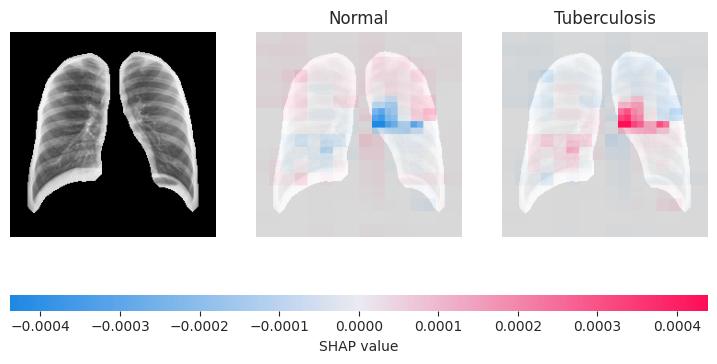

In [37]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np
import shap
import matplotlib.pyplot as plt

# Define the image size
img_size = (224, 224)  # Adjust this to match your model's input size

# Define the image path
img_path = '/kaggle/working/Image Files/Shenzhen_Custom_Masks/Tuberculosis/CHNCXR_0343_1.png'
#img_path="/content/Shenzhen/Normal/CHNCXR_0010_0.png"
#img_path="/content/Shenzhen/Normal/CHNCXR_0028_0.png"
#img_path="/content/Shenzhen/Tuberculosis/CHNCXR_0327_1.png"
#img_path="/content/Shenzhen/Tuberculosis/CHNCXR_0333_1.png"
#img_path="/content/Shenzhen/Tuberculosis/CHNCXR_0360_1.png"

# Load and preprocess the image
img = image.load_img(img_path, target_size=img_size)
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = tf.keras.applications.efficientnet.preprocess_input(img_array)

# Make a prediction
predictions = model.predict(img_array)

# Get the class with the highest probability
predicted_class = np.argmax(predictions, axis=1)

# Assuming you have a list of class names
class_names = list(train_gen.class_indices.keys())  # Ensure train_gen is defined
predicted_class_name = class_names[predicted_class[0]]

print(f'The predicted class is: {predicted_class_name}')

# Define the function for SHAP
def f(x):
    tmp = x.copy()
    return model(tmp)

# Create the masker using the shape of the loaded image
masker_blur = shap.maskers.Image("blur(224,224)", img_array.shape[1:])

# Create the explainer
explainer = shap.Explainer(f, masker_blur, output_names=class_names)

# Compute SHAP values
shap_values = explainer(img_array, max_evals=5000, batch_size=50)

# Normalize SHAP values to fall within the range [0, 1]
#shap_values.values = np.clip(shap_values.values, -1, 1)
#shap_values.values = (shap_values.values - shap_values.values.min()) / (shap_values.values.max() - shap_values.values.min())

# Normalize the image array to [0, 1] range for plotting
img_array_display = (img_array - img_array.min()) / (img_array.max() - img_array.min())

# Plot the SHAP values
shap.image_plot(shap_values, img_array_display, labels=class_names)

Last convolutional layer name: top_conv


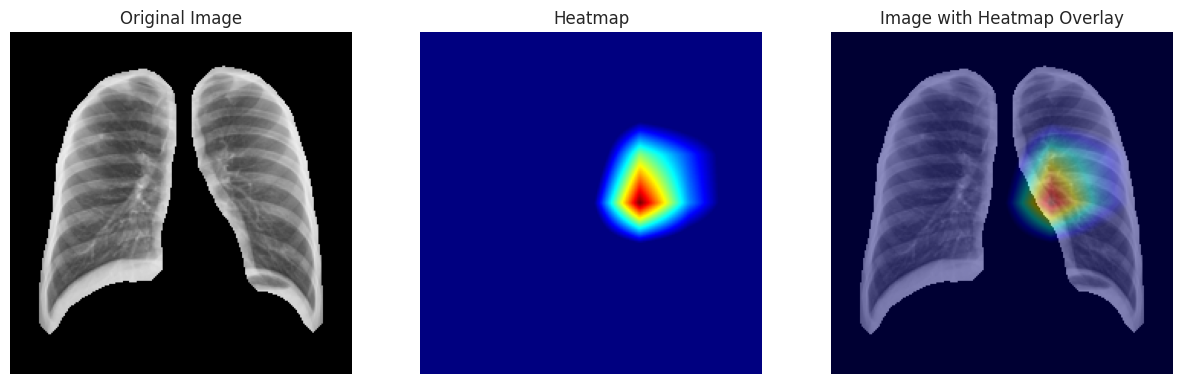

In [38]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.efficientnet import preprocess_input
import numpy as np
import cv2
import matplotlib.pyplot as plt

def make_gradcampp_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape1:
        with tf.GradientTape() as tape2:
            with tf.GradientTape() as tape3:
                last_conv_layer_output, preds = grad_model(img_array)
                if pred_index is None:
                    pred_index = tf.argmax(preds[0])
                class_channel = preds[:, pred_index]

            grads = tape3.gradient(class_channel, last_conv_layer_output)
        grads2 = tape2.gradient(class_channel, last_conv_layer_output)
    grads3 = tape1.gradient(class_channel, last_conv_layer_output)

    alpha_num = grads2**2
    alpha_denom = 2 * grads2**2 + tf.reduce_sum(last_conv_layer_output * grads3, axis=(1, 2))
    alpha_denom = tf.where(alpha_denom != 0, alpha_denom, tf.ones(alpha_denom.shape))
    alphas = alpha_num / alpha_denom
    weights = tf.reduce_sum(alphas * tf.maximum(grads, 0), axis=(1, 2))

    last_conv_layer_output = last_conv_layer_output[0]
    cam = tf.reduce_sum(weights[:, tf.newaxis, tf.newaxis] * last_conv_layer_output, axis=-1)

    heatmap = tf.maximum(cam, 0) / tf.math.reduce_max(cam)
    heatmap = tf.image.resize(heatmap[..., tf.newaxis], (img_array.shape[1], img_array.shape[2]))
    heatmap = tf.squeeze(heatmap)

    return heatmap.numpy()

def display_gradcam(img_path, heatmap, alpha=0.4, threshold_percentile=90):
    # Load and preprocess the original image
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Resize heatmap to match the original image size
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

    # Apply dynamic threshold to the heatmap based on percentile
    threshold_value = np.percentile(heatmap, threshold_percentile)
    heatmap = np.maximum(heatmap - threshold_value, 0)
    heatmap = heatmap / np.max(heatmap)  # Normalize the heatmap

    # Apply colormap to the heatmap
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)  # Convert heatmap to RGB for blending

    # Blend heatmap with the original image
    blended_img = (heatmap * alpha) + (img * (1 - alpha))
    blended_img = np.clip(blended_img, 0, 255).astype(np.uint8)

    # Plotting
    plt.figure(figsize=(15, 5))

    # Plot original image
    plt.subplot(1, 3, 1)
    plt.imshow(img)
    plt.title('Original Image')
    plt.axis('off')

    # Plot heatmap
    plt.subplot(1, 3, 2)
    plt.imshow(heatmap)
    plt.title('Heatmap')
    plt.axis('off')

    # Plot original image with heatmap overlay
    plt.subplot(1, 3, 3)
    plt.imshow(blended_img)
    plt.title('Image with Heatmap Overlay')
    plt.axis('off')

    plt.show()

def get_last_conv_layer_name(model):
    for layer in reversed(model.layers):
        if isinstance(layer, tf.keras.layers.Conv2D):
            return layer.name
    return None

# Example usage
img_path = '/kaggle/working/Image Files/Shenzhen_Custom_Masks/Tuberculosis/CHNCXR_0343_1.png'
#img_path="/content/Shenzhen/Normal/CHNCXR_0010_0.png"
#img_path="/content/Shenzhen/Normal/CHNCXR_0028_0.png"
#img_path="/content/Shenzhen/Tuberculosis/CHNCXR_0327_1.png"
#img_path="/content/Shenzhen/Tuberculosis/CHNCXR_0333_1.png"
#img_path = "/content/Shenzhen/Tuberculosis/CHNCXR_0360_1.png"
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

# Assuming 'base_model' is your model instance
last_conv_layer_name = get_last_conv_layer_name(base_model)
print("Last convolutional layer name:", last_conv_layer_name)

# Create the heatmap
heatmap = make_gradcampp_heatmap(x, base_model, last_conv_layer_name)

display_gradcam(img_path, heatmap)


# # # # 330

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step


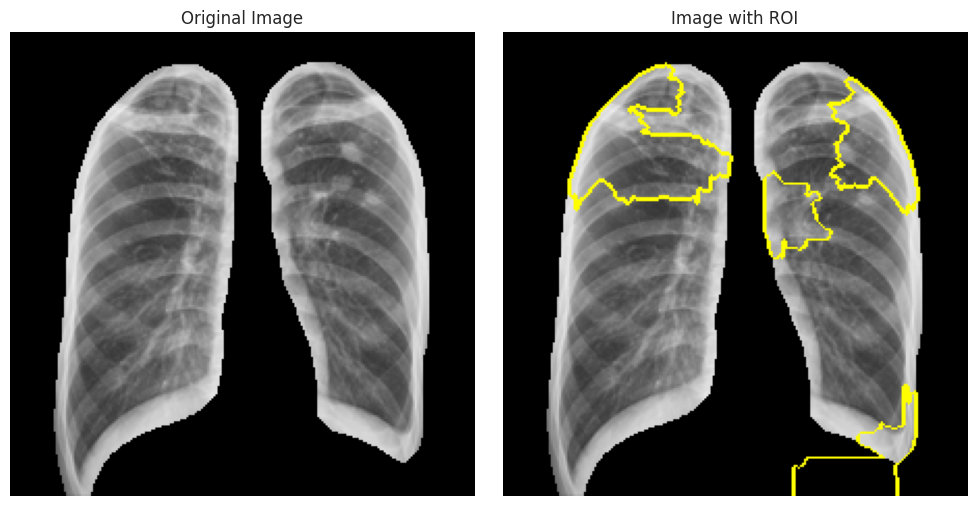

In [39]:
import matplotlib.pyplot as plt
import numpy as np
from lime import lime_image
from skimage.segmentation import mark_boundaries
from PIL import Image

# Initialize LIME image explainer
explainer = lime_image.LimeImageExplainer()

# Example preprocessing function (replace with your preprocessing logic)
def preprocess_image(img_path):
    # Load and preprocess your image (example assumes resizing to 224x224)
    img = Image.open(img_path)
    img = img.convert('RGB')  # Ensure RGB mode
    img = img.resize((224, 224))  # Resize to model input size
    img = np.array(img)  # Convert PIL image to numpy array
    return img

# Example prediction function (replace with your model prediction function)
def predict_fn(images):
    # Assuming 'model' is your trained Keras model
    return model.predict(images)

# Select an image to explain
img_path = '/kaggle/working/Image Files/Shenzhen_Custom_Masks/Tuberculosis/CHNCXR_0330_1.png'
#img_path="/content/Shenzhen/Normal/CHNCXR_0010_0.png"
#img_path="/content/Shenzhen/Normal/CHNCXR_0028_0.png"
#img_path="/content/Shenzhen/Tuberculosis/CHNCXR_0327_1.png"
#img_path="/content/Shenzhen/Tuberculosis/CHNCXR_0333_1.png"
#img_path="/content/Shenzhen/Tuberculosis/CHNCXR_0360_1.png"
img = preprocess_image(img_path)

# Ensure the image is in the correct shape for LIME
img = img.astype(np.float32) / 255.0  # Normalize to [0, 1] if needed

# Explain the prediction
explanation = explainer.explain_instance(
    image=img,
    classifier_fn=predict_fn,
    top_labels=1,
    hide_color=0,
    num_samples=1000
)

# Get the explanation for the top class
temp, mask = explanation.get_image_and_mask(
    label=explanation.top_labels[0],
    positive_only=False,
    num_features=5,
    hide_rest=False
)

# Overlay the explanation mask on the original image
img_with_mask = mark_boundaries(np.array(img), mask)

# Show the original image with overlaid ROI
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(np.array(img))
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(img_with_mask)
plt.title('Image with ROI')
plt.axis('off')

plt.tight_layout()
plt.show()


1/1 [==============================] - 0s 26ms/step
The predicted class is: Tuberculosis


  0%|          | 0/4998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.39s/it]               


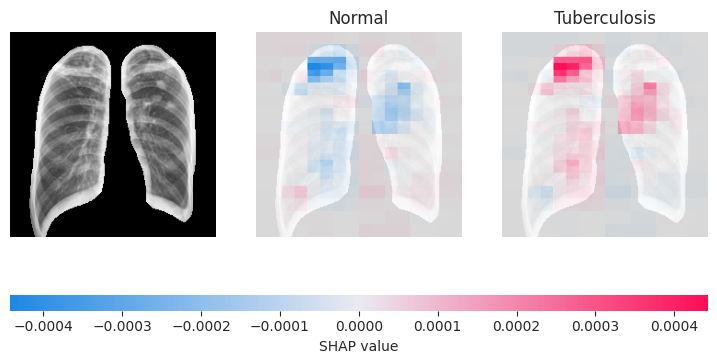

In [40]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np
import shap
import matplotlib.pyplot as plt

# Define the image size
img_size = (224, 224)  # Adjust this to match your model's input size

# Define the image path
img_path = '/kaggle/working/Image Files/Shenzhen_Custom_Masks/Tuberculosis/CHNCXR_0330_1.png'
#img_path="/content/Shenzhen/Normal/CHNCXR_0010_0.png"
#img_path="/content/Shenzhen/Normal/CHNCXR_0028_0.png"
#img_path="/content/Shenzhen/Tuberculosis/CHNCXR_0327_1.png"
#img_path="/content/Shenzhen/Tuberculosis/CHNCXR_0333_1.png"
#img_path="/content/Shenzhen/Tuberculosis/CHNCXR_0360_1.png"

# Load and preprocess the image
img = image.load_img(img_path, target_size=img_size)
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = tf.keras.applications.efficientnet.preprocess_input(img_array)

# Make a prediction
predictions = model.predict(img_array)

# Get the class with the highest probability
predicted_class = np.argmax(predictions, axis=1)

# Assuming you have a list of class names
class_names = list(train_gen.class_indices.keys())  # Ensure train_gen is defined
predicted_class_name = class_names[predicted_class[0]]

print(f'The predicted class is: {predicted_class_name}')

# Define the function for SHAP
def f(x):
    tmp = x.copy()
    return model(tmp)

# Create the masker using the shape of the loaded image
masker_blur = shap.maskers.Image("blur(224,224)", img_array.shape[1:])

# Create the explainer
explainer = shap.Explainer(f, masker_blur, output_names=class_names)

# Compute SHAP values
shap_values = explainer(img_array, max_evals=5000, batch_size=50)

# Normalize SHAP values to fall within the range [0, 1]
#shap_values.values = np.clip(shap_values.values, -1, 1)
#shap_values.values = (shap_values.values - shap_values.values.min()) / (shap_values.values.max() - shap_values.values.min())

# Normalize the image array to [0, 1] range for plotting
img_array_display = (img_array - img_array.min()) / (img_array.max() - img_array.min())

# Plot the SHAP values
shap.image_plot(shap_values, img_array_display, labels=class_names)


Last convolutional layer name: top_conv


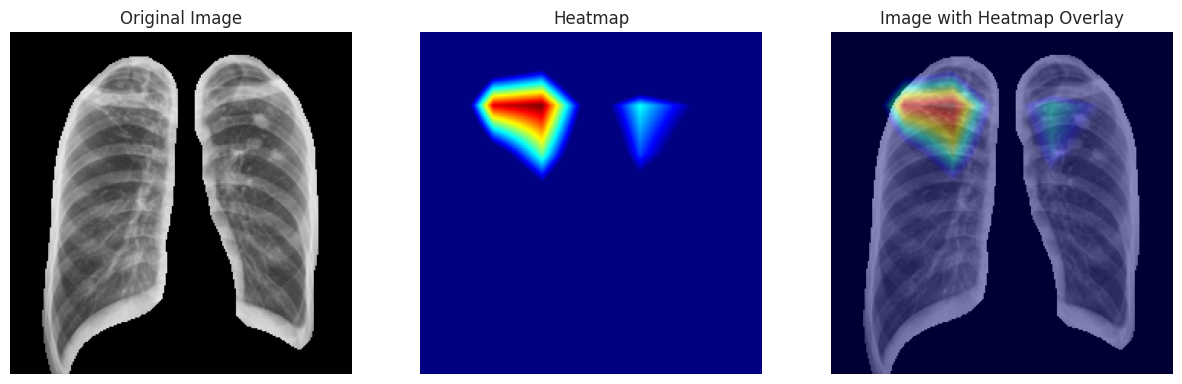

In [41]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.efficientnet import preprocess_input
import numpy as np
import cv2
import matplotlib.pyplot as plt

def make_gradcampp_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape1:
        with tf.GradientTape() as tape2:
            with tf.GradientTape() as tape3:
                last_conv_layer_output, preds = grad_model(img_array)
                if pred_index is None:
                    pred_index = tf.argmax(preds[0])
                class_channel = preds[:, pred_index]

            grads = tape3.gradient(class_channel, last_conv_layer_output)
        grads2 = tape2.gradient(class_channel, last_conv_layer_output)
    grads3 = tape1.gradient(class_channel, last_conv_layer_output)

    alpha_num = grads2**2
    alpha_denom = 2 * grads2**2 + tf.reduce_sum(last_conv_layer_output * grads3, axis=(1, 2))
    alpha_denom = tf.where(alpha_denom != 0, alpha_denom, tf.ones(alpha_denom.shape))
    alphas = alpha_num / alpha_denom
    weights = tf.reduce_sum(alphas * tf.maximum(grads, 0), axis=(1, 2))

    last_conv_layer_output = last_conv_layer_output[0]
    cam = tf.reduce_sum(weights[:, tf.newaxis, tf.newaxis] * last_conv_layer_output, axis=-1)

    heatmap = tf.maximum(cam, 0) / tf.math.reduce_max(cam)
    heatmap = tf.image.resize(heatmap[..., tf.newaxis], (img_array.shape[1], img_array.shape[2]))
    heatmap = tf.squeeze(heatmap)

    return heatmap.numpy()

def display_gradcam(img_path, heatmap, alpha=0.4, threshold_percentile=90):
    # Load and preprocess the original image
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Resize heatmap to match the original image size
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

    # Apply dynamic threshold to the heatmap based on percentile
    threshold_value = np.percentile(heatmap, threshold_percentile)
    heatmap = np.maximum(heatmap - threshold_value, 0)
    heatmap = heatmap / np.max(heatmap)  # Normalize the heatmap

    # Apply colormap to the heatmap
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)  # Convert heatmap to RGB for blending

    # Blend heatmap with the original image
    blended_img = (heatmap * alpha) + (img * (1 - alpha))
    blended_img = np.clip(blended_img, 0, 255).astype(np.uint8)

    # Plotting
    plt.figure(figsize=(15, 5))

    # Plot original image
    plt.subplot(1, 3, 1)
    plt.imshow(img)
    plt.title('Original Image')
    plt.axis('off')

    # Plot heatmap
    plt.subplot(1, 3, 2)
    plt.imshow(heatmap)
    plt.title('Heatmap')
    plt.axis('off')

    # Plot original image with heatmap overlay
    plt.subplot(1, 3, 3)
    plt.imshow(blended_img)
    plt.title('Image with Heatmap Overlay')
    plt.axis('off')

    plt.show()

def get_last_conv_layer_name(model):
    for layer in reversed(model.layers):
        if isinstance(layer, tf.keras.layers.Conv2D):
            return layer.name
    return None

# Example usage
img_path = '/kaggle/working/Image Files/Shenzhen_Custom_Masks/Tuberculosis/CHNCXR_0330_1.png'
#img_path="/content/Shenzhen/Normal/CHNCXR_0010_0.png"
#img_path="/content/Shenzhen/Normal/CHNCXR_0028_0.png"
#img_path="/content/Shenzhen/Tuberculosis/CHNCXR_0327_1.png"
#img_path="/content/Shenzhen/Tuberculosis/CHNCXR_0333_1.png"
#img_path = "/content/Shenzhen/Tuberculosis/CHNCXR_0360_1.png"
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

# Assuming 'base_model' is your model instance
last_conv_layer_name = get_last_conv_layer_name(base_model)
print("Last convolutional layer name:", last_conv_layer_name)

# Create the heatmap
heatmap = make_gradcampp_heatmap(x, base_model, last_conv_layer_name)

display_gradcam(img_path, heatmap)


# # # # 78

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


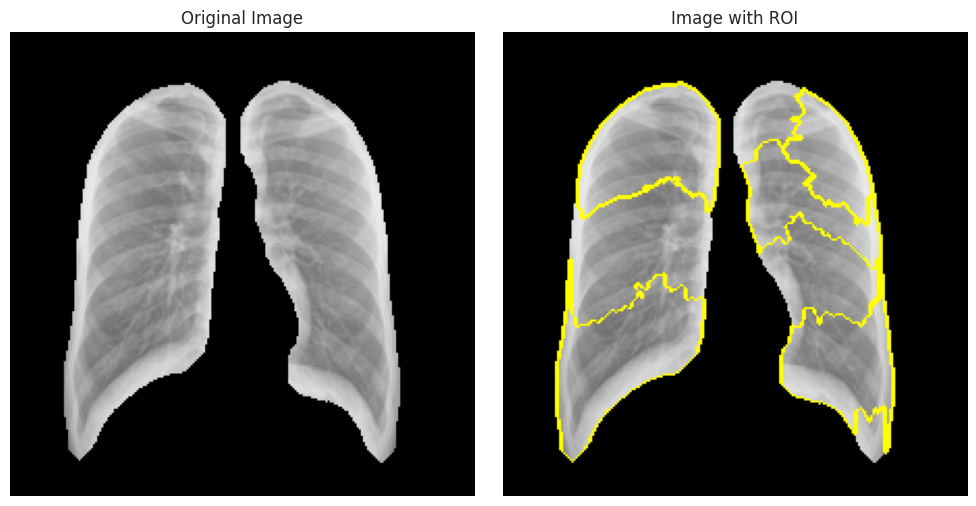

In [42]:
import matplotlib.pyplot as plt
import numpy as np
from lime import lime_image
from skimage.segmentation import mark_boundaries
from PIL import Image

# Initialize LIME image explainer
explainer = lime_image.LimeImageExplainer()

# Example preprocessing function (replace with your preprocessing logic)
def preprocess_image(img_path):
    # Load and preprocess your image (example assumes resizing to 224x224)
    img = Image.open(img_path)
    img = img.convert('RGB')  # Ensure RGB mode
    img = img.resize((224, 224))  # Resize to model input size
    img = np.array(img)  # Convert PIL image to numpy array
    return img

# Example prediction function (replace with your model prediction function)
def predict_fn(images):
    # Assuming 'model' is your trained Keras model
    return model.predict(images)

# Select an image to explain
img_path = '/kaggle/working/Image Files/Shenzhen_Custom_Masks/Normal/CHNCXR_0078_0.png'
#img_path="/content/Shenzhen/Normal/CHNCXR_0010_0.png"
#img_path="/content/Shenzhen/Normal/CHNCXR_0028_0.png"
#img_path="/content/Shenzhen/Tuberculosis/CHNCXR_0327_1.png"
#img_path="/content/Shenzhen/Tuberculosis/CHNCXR_0333_1.png"
#img_path="/content/Shenzhen/Tuberculosis/CHNCXR_0360_1.png"
img = preprocess_image(img_path)

# Ensure the image is in the correct shape for LIME
img = img.astype(np.float32) / 255.0  # Normalize to [0, 1] if needed

# Explain the prediction
explanation = explainer.explain_instance(
    image=img,
    classifier_fn=predict_fn,
    top_labels=1,
    hide_color=0,
    num_samples=1000
)

# Get the explanation for the top class
temp, mask = explanation.get_image_and_mask(
    label=explanation.top_labels[0],
    positive_only=False,
    num_features=5,
    hide_rest=False
)

# Overlay the explanation mask on the original image
img_with_mask = mark_boundaries(np.array(img), mask)

# Show the original image with overlaid ROI
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(np.array(img))
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(img_with_mask)
plt.title('Image with ROI')
plt.axis('off')

plt.tight_layout()
plt.show()


1/1 [==============================] - 0s 26ms/step
The predicted class is: Normal


  0%|          | 0/4998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.89s/it]               


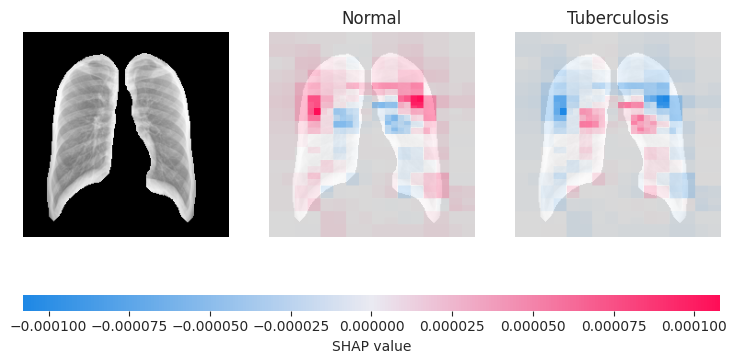

In [43]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np
import shap
import matplotlib.pyplot as plt

# Define the image size
img_size = (224, 224)  # Adjust this to match your model's input size

# Define the image path
img_path = '/kaggle/working/Image Files/Shenzhen_Custom_Masks/Normal/CHNCXR_0078_0.png'
#img_path="/content/Shenzhen/Normal/CHNCXR_0010_0.png"
#img_path="/content/Shenzhen/Normal/CHNCXR_0028_0.png"
#img_path="/content/Shenzhen/Tuberculosis/CHNCXR_0327_1.png"
#img_path="/content/Shenzhen/Tuberculosis/CHNCXR_0333_1.png"
#img_path="/content/Shenzhen/Tuberculosis/CHNCXR_0360_1.png"

# Load and preprocess the image
img = image.load_img(img_path, target_size=img_size)
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = tf.keras.applications.efficientnet.preprocess_input(img_array)

# Make a prediction
predictions = model.predict(img_array)

# Get the class with the highest probability
predicted_class = np.argmax(predictions, axis=1)

# Assuming you have a list of class names
class_names = list(train_gen.class_indices.keys())  # Ensure train_gen is defined
predicted_class_name = class_names[predicted_class[0]]

print(f'The predicted class is: {predicted_class_name}')

# Define the function for SHAP
def f(x):
    tmp = x.copy()
    return model(tmp)

# Create the masker using the shape of the loaded image
masker_blur = shap.maskers.Image("blur(224,224)", img_array.shape[1:])

# Create the explainer
explainer = shap.Explainer(f, masker_blur, output_names=class_names)

# Compute SHAP values
shap_values = explainer(img_array, max_evals=5000, batch_size=50)

# Normalize SHAP values to fall within the range [0, 1]
#shap_values.values = np.clip(shap_values.values, -1, 1)
#shap_values.values = (shap_values.values - shap_values.values.min()) / (shap_values.values.max() - shap_values.values.min())

# Normalize the image array to [0, 1] range for plotting
img_array_display = (img_array - img_array.min()) / (img_array.max() - img_array.min())

# Plot the SHAP values
shap.image_plot(shap_values, img_array_display, labels=class_names)


Last convolutional layer name: top_conv


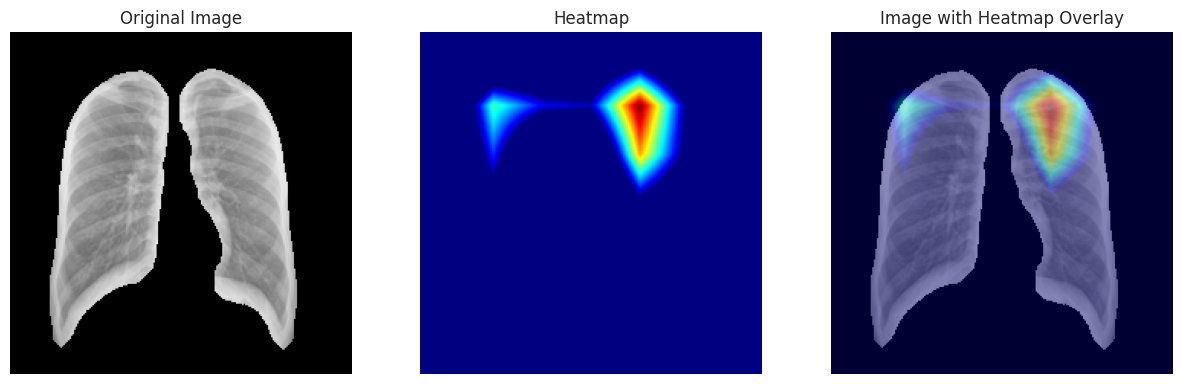

In [44]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.efficientnet import preprocess_input
import numpy as np
import cv2
import matplotlib.pyplot as plt

def make_gradcampp_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape1:
        with tf.GradientTape() as tape2:
            with tf.GradientTape() as tape3:
                last_conv_layer_output, preds = grad_model(img_array)
                if pred_index is None:
                    pred_index = tf.argmax(preds[0])
                class_channel = preds[:, pred_index]

            grads = tape3.gradient(class_channel, last_conv_layer_output)
        grads2 = tape2.gradient(class_channel, last_conv_layer_output)
    grads3 = tape1.gradient(class_channel, last_conv_layer_output)

    alpha_num = grads2**2
    alpha_denom = 2 * grads2**2 + tf.reduce_sum(last_conv_layer_output * grads3, axis=(1, 2))
    alpha_denom = tf.where(alpha_denom != 0, alpha_denom, tf.ones(alpha_denom.shape))
    alphas = alpha_num / alpha_denom
    weights = tf.reduce_sum(alphas * tf.maximum(grads, 0), axis=(1, 2))

    last_conv_layer_output = last_conv_layer_output[0]
    cam = tf.reduce_sum(weights[:, tf.newaxis, tf.newaxis] * last_conv_layer_output, axis=-1)

    heatmap = tf.maximum(cam, 0) / tf.math.reduce_max(cam)
    heatmap = tf.image.resize(heatmap[..., tf.newaxis], (img_array.shape[1], img_array.shape[2]))
    heatmap = tf.squeeze(heatmap)

    return heatmap.numpy()

def display_gradcam(img_path, heatmap, alpha=0.4, threshold_percentile=90):
    # Load and preprocess the original image
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Resize heatmap to match the original image size
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

    # Apply dynamic threshold to the heatmap based on percentile
    threshold_value = np.percentile(heatmap, threshold_percentile)
    heatmap = np.maximum(heatmap - threshold_value, 0)
    heatmap = heatmap / np.max(heatmap)  # Normalize the heatmap

    # Apply colormap to the heatmap
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)  # Convert heatmap to RGB for blending

    # Blend heatmap with the original image
    blended_img = (heatmap * alpha) + (img * (1 - alpha))
    blended_img = np.clip(blended_img, 0, 255).astype(np.uint8)

    # Plotting
    plt.figure(figsize=(15, 5))

    # Plot original image
    plt.subplot(1, 3, 1)
    plt.imshow(img)
    plt.title('Original Image')
    plt.axis('off')

    # Plot heatmap
    plt.subplot(1, 3, 2)
    plt.imshow(heatmap)
    plt.title('Heatmap')
    plt.axis('off')

    # Plot original image with heatmap overlay
    plt.subplot(1, 3, 3)
    plt.imshow(blended_img)
    plt.title('Image with Heatmap Overlay')
    plt.axis('off')

    plt.show()

def get_last_conv_layer_name(model):
    for layer in reversed(model.layers):
        if isinstance(layer, tf.keras.layers.Conv2D):
            return layer.name
    return None

# Example usage
img_path = '/kaggle/working/Image Files/Shenzhen_Custom_Masks/Normal/CHNCXR_0078_0.png'
#img_path="/content/Shenzhen/Normal/CHNCXR_0010_0.png"
#img_path="/content/Shenzhen/Normal/CHNCXR_0028_0.png"
#img_path="/content/Shenzhen/Tuberculosis/CHNCXR_0327_1.png"
#img_path="/content/Shenzhen/Tuberculosis/CHNCXR_0333_1.png"
#img_path = "/content/Shenzhen/Tuberculosis/CHNCXR_0360_1.png"
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

# Assuming 'base_model' is your model instance
last_conv_layer_name = get_last_conv_layer_name(base_model)
print("Last convolutional layer name:", last_conv_layer_name)

# Create the heatmap
heatmap = make_gradcampp_heatmap(x, base_model, last_conv_layer_name)

display_gradcam(img_path, heatmap)


# # # 100

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step


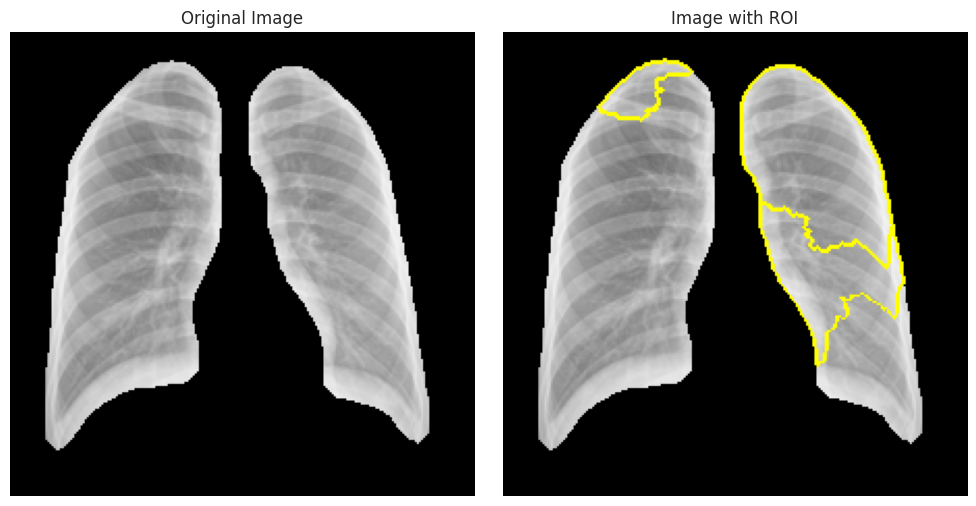

In [69]:
import matplotlib.pyplot as plt
import numpy as np
from lime import lime_image
from skimage.segmentation import mark_boundaries
from PIL import Image

# Initialize LIME image explainer
explainer = lime_image.LimeImageExplainer()

# Example preprocessing function (replace with your preprocessing logic)
def preprocess_image(img_path):
    # Load and preprocess your image (example assumes resizing to 224x224)
    img = Image.open(img_path)
    img = img.convert('RGB')  # Ensure RGB mode
    img = img.resize((224, 224))  # Resize to model input size
    img = np.array(img)  # Convert PIL image to numpy array
    return img

# Example prediction function (replace with your model prediction function)
def predict_fn(images):
    # Assuming 'model' is your trained Keras model
    return model.predict(images)

# Select an image to explain
img_path = '/kaggle/working/Image Files/Shenzhen_Custom_Masks/Normal/CHNCXR_0100_0.png'
#img_path="/content/Shenzhen/Normal/CHNCXR_0010_0.png"
#img_path="/content/Shenzhen/Normal/CHNCXR_0028_0.png"
#img_path="/content/Shenzhen/Tuberculosis/CHNCXR_0327_1.png"
#img_path="/content/Shenzhen/Tuberculosis/CHNCXR_0333_1.png"
#img_path="/content/Shenzhen/Tuberculosis/CHNCXR_0360_1.png"
img = preprocess_image(img_path)

# Ensure the image is in the correct shape for LIME
img = img.astype(np.float32) / 255.0  # Normalize to [0, 1] if needed

# Explain the prediction
explanation = explainer.explain_instance(
    image=img,
    classifier_fn=predict_fn,
    top_labels=1,
    hide_color=0,
    num_samples=1000
)

# Get the explanation for the top class
temp, mask = explanation.get_image_and_mask(
    label=explanation.top_labels[0],
    positive_only=False,
    num_features=5,
    hide_rest=False
)

# Overlay the explanation mask on the original image
img_with_mask = mark_boundaries(np.array(img), mask)

# Show the original image with overlaid ROI
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(np.array(img))
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(img_with_mask)
plt.title('Image with ROI')
plt.axis('off')

plt.tight_layout()
plt.show()

1/1 [==============================] - 0s 27ms/step
The predicted class is: Normal


  0%|          | 0/4998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.31s/it]               


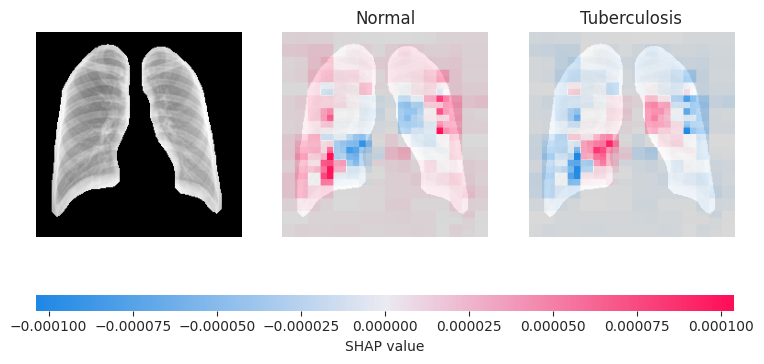

In [66]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np
import shap
import matplotlib.pyplot as plt

# Define the image size
img_size = (224, 224)  # Adjust this to match your model's input size

# Define the image path
img_path = '/kaggle/working/Image Files/Shenzhen_Custom_Masks/Normal/CHNCXR_0100_0.png'
#img_path="/content/Shenzhen/Normal/CHNCXR_0010_0.png"
#img_path="/content/Shenzhen/Normal/CHNCXR_0028_0.png"
#img_path="/content/Shenzhen/Tuberculosis/CHNCXR_0327_1.png"
#img_path="/content/Shenzhen/Tuberculosis/CHNCXR_0333_1.png"
#img_path="/content/Shenzhen/Tuberculosis/CHNCXR_0360_1.png"

# Load and preprocess the image
img = image.load_img(img_path, target_size=img_size)
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = tf.keras.applications.efficientnet.preprocess_input(img_array)

# Make a prediction
predictions = model.predict(img_array)

# Get the class with the highest probability
predicted_class = np.argmax(predictions, axis=1)

# Assuming you have a list of class names
class_names = list(train_gen.class_indices.keys())  # Ensure train_gen is defined
predicted_class_name = class_names[predicted_class[0]]

print(f'The predicted class is: {predicted_class_name}')

# Define the function for SHAP
def f(x):
    tmp = x.copy()
    return model(tmp)

# Create the masker using the shape of the loaded image
masker_blur = shap.maskers.Image("blur(224,224)", img_array.shape[1:])

# Create the explainer
explainer = shap.Explainer(f, masker_blur, output_names=class_names)

# Compute SHAP values
shap_values = explainer(img_array, max_evals=5000, batch_size=50)

# Normalize SHAP values to fall within the range [0, 1]
#shap_values.values = np.clip(shap_values.values, -1, 1)
#shap_values.values = (shap_values.values - shap_values.values.min()) / (shap_values.values.max() - shap_values.values.min())

# Normalize the image array to [0, 1] range for plotting
img_array_display = (img_array - img_array.min()) / (img_array.max() - img_array.min())

# Plot the SHAP values
shap.image_plot(shap_values, img_array_display, labels=class_names)

Last convolutional layer name: top_conv


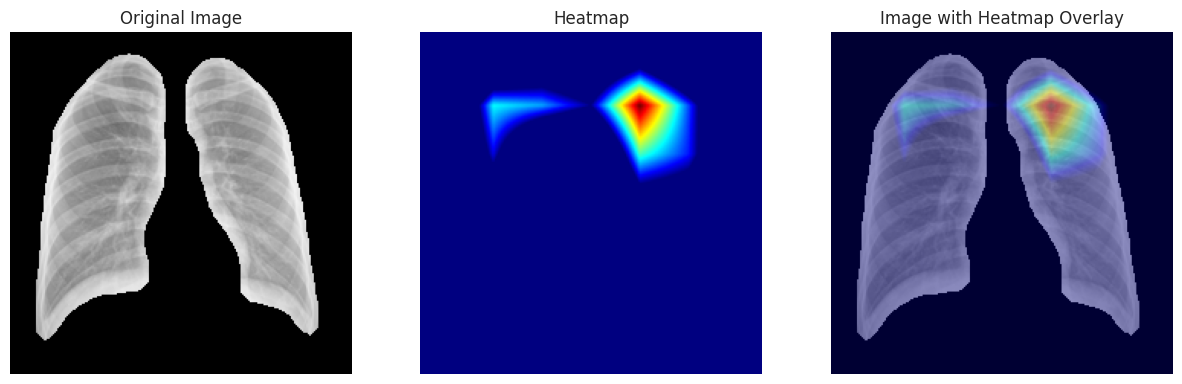

In [67]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.efficientnet import preprocess_input
import numpy as np
import cv2
import matplotlib.pyplot as plt

def make_gradcampp_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape1:
        with tf.GradientTape() as tape2:
            with tf.GradientTape() as tape3:
                last_conv_layer_output, preds = grad_model(img_array)
                if pred_index is None:
                    pred_index = tf.argmax(preds[0])
                class_channel = preds[:, pred_index]

            grads = tape3.gradient(class_channel, last_conv_layer_output)
        grads2 = tape2.gradient(class_channel, last_conv_layer_output)
    grads3 = tape1.gradient(class_channel, last_conv_layer_output)

    alpha_num = grads2**2
    alpha_denom = 2 * grads2**2 + tf.reduce_sum(last_conv_layer_output * grads3, axis=(1, 2))
    alpha_denom = tf.where(alpha_denom != 0, alpha_denom, tf.ones(alpha_denom.shape))
    alphas = alpha_num / alpha_denom
    weights = tf.reduce_sum(alphas * tf.maximum(grads, 0), axis=(1, 2))

    last_conv_layer_output = last_conv_layer_output[0]
    cam = tf.reduce_sum(weights[:, tf.newaxis, tf.newaxis] * last_conv_layer_output, axis=-1)

    heatmap = tf.maximum(cam, 0) / tf.math.reduce_max(cam)
    heatmap = tf.image.resize(heatmap[..., tf.newaxis], (img_array.shape[1], img_array.shape[2]))
    heatmap = tf.squeeze(heatmap)

    return heatmap.numpy()

def display_gradcam(img_path, heatmap, alpha=0.4, threshold_percentile=90):
    # Load and preprocess the original image
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Resize heatmap to match the original image size
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

    # Apply dynamic threshold to the heatmap based on percentile
    threshold_value = np.percentile(heatmap, threshold_percentile)
    heatmap = np.maximum(heatmap - threshold_value, 0)
    heatmap = heatmap / np.max(heatmap)  # Normalize the heatmap

    # Apply colormap to the heatmap
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)  # Convert heatmap to RGB for blending

    # Blend heatmap with the original image
    blended_img = (heatmap * alpha) + (img * (1 - alpha))
    blended_img = np.clip(blended_img, 0, 255).astype(np.uint8)

    # Plotting
    plt.figure(figsize=(15, 5))

    # Plot original image
    plt.subplot(1, 3, 1)
    plt.imshow(img)
    plt.title('Original Image')
    plt.axis('off')

    # Plot heatmap
    plt.subplot(1, 3, 2)
    plt.imshow(heatmap)
    plt.title('Heatmap')
    plt.axis('off')

    # Plot original image with heatmap overlay
    plt.subplot(1, 3, 3)
    plt.imshow(blended_img)
    plt.title('Image with Heatmap Overlay')
    plt.axis('off')

    plt.show()

def get_last_conv_layer_name(model):
    for layer in reversed(model.layers):
        if isinstance(layer, tf.keras.layers.Conv2D):
            return layer.name
    return None

# Example usage
img_path = '/kaggle/working/Image Files/Shenzhen_Custom_Masks/Normal/CHNCXR_0100_0.png'
#img_path="/content/Shenzhen/Normal/CHNCXR_0010_0.png"
#img_path="/content/Shenzhen/Normal/CHNCXR_0028_0.png"
#img_path="/content/Shenzhen/Tuberculosis/CHNCXR_0327_1.png"
#img_path="/content/Shenzhen/Tuberculosis/CHNCXR_0333_1.png"
#img_path = "/content/Shenzhen/Tuberculosis/CHNCXR_0360_1.png"
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

# Assuming 'base_model' is your model instance
last_conv_layer_name = get_last_conv_layer_name(base_model)
print("Last convolutional layer name:", last_conv_layer_name)

# Create the heatmap
heatmap = make_gradcampp_heatmap(x, base_model, last_conv_layer_name)

display_gradcam(img_path, heatmap)

# # # # 350

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step


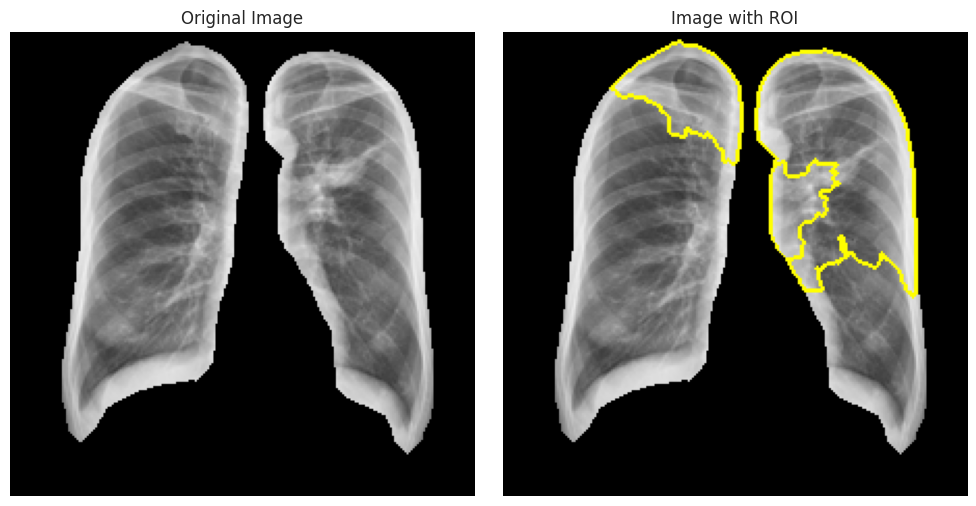

In [72]:
import matplotlib.pyplot as plt
import numpy as np
from lime import lime_image
from skimage.segmentation import mark_boundaries
from PIL import Image

# Initialize LIME image explainer
explainer = lime_image.LimeImageExplainer()

# Example preprocessing function (replace with your preprocessing logic)
def preprocess_image(img_path):
    # Load and preprocess your image (example assumes resizing to 224x224)
    img = Image.open(img_path)
    img = img.convert('RGB')  # Ensure RGB mode
    img = img.resize((224, 224))  # Resize to model input size
    img = np.array(img)  # Convert PIL image to numpy array
    return img

# Example prediction function (replace with your model prediction function)
def predict_fn(images):
    # Assuming 'model' is your trained Keras model
    return model.predict(images)

# Select an image to explain
img_path = '/kaggle/working/Image Files/Shenzhen_Custom_Masks/Tuberculosis/CHNCXR_0350_1.png'
#img_path="/content/Shenzhen/Normal/CHNCXR_0010_0.png"
#img_path="/content/Shenzhen/Normal/CHNCXR_0028_0.png"
#img_path="/content/Shenzhen/Tuberculosis/CHNCXR_0327_1.png"
#img_path="/content/Shenzhen/Tuberculosis/CHNCXR_0333_1.png"
#img_path="/content/Shenzhen/Tuberculosis/CHNCXR_0360_1.png"
img = preprocess_image(img_path)

# Ensure the image is in the correct shape for LIME
img = img.astype(np.float32) / 255.0  # Normalize to [0, 1] if needed

# Explain the prediction
explanation = explainer.explain_instance(
    image=img,
    classifier_fn=predict_fn,
    top_labels=1,
    hide_color=0,
    num_samples=1000
)

# Get the explanation for the top class
temp, mask = explanation.get_image_and_mask(
    label=explanation.top_labels[0],
    positive_only=False,
    num_features=5,
    hide_rest=False
)

# Overlay the explanation mask on the original image
img_with_mask = mark_boundaries(np.array(img), mask)

# Show the original image with overlaid ROI
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(np.array(img))
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(img_with_mask)
plt.title('Image with ROI')
plt.axis('off')

plt.tight_layout()
plt.show()


1/1 [==============================] - 0s 27ms/step
The predicted class is: Tuberculosis


  0%|          | 0/4998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.47s/it]               


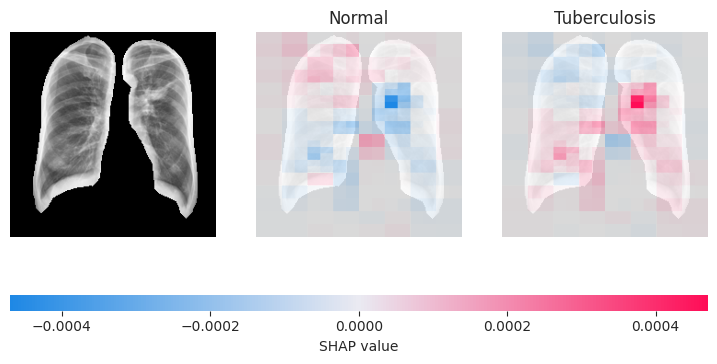

In [70]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np
import shap
import matplotlib.pyplot as plt

# Define the image size
img_size = (224, 224)  # Adjust this to match your model's input size

# Define the image path
img_path = '/kaggle/working/Image Files/Shenzhen_Custom_Masks/Tuberculosis/CHNCXR_0350_1.png'
#img_path="/content/Shenzhen/Normal/CHNCXR_0010_0.png"
#img_path="/content/Shenzhen/Normal/CHNCXR_0028_0.png"
#img_path="/content/Shenzhen/Tuberculosis/CHNCXR_0327_1.png"
#img_path="/content/Shenzhen/Tuberculosis/CHNCXR_0333_1.png"
#img_path="/content/Shenzhen/Tuberculosis/CHNCXR_0360_1.png"

# Load and preprocess the image
img = image.load_img(img_path, target_size=img_size)
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = tf.keras.applications.efficientnet.preprocess_input(img_array)

# Make a prediction
predictions = model.predict(img_array)

# Get the class with the highest probability
predicted_class = np.argmax(predictions, axis=1)

# Assuming you have a list of class names
class_names = list(train_gen.class_indices.keys())  # Ensure train_gen is defined
predicted_class_name = class_names[predicted_class[0]]

print(f'The predicted class is: {predicted_class_name}')

# Define the function for SHAP
def f(x):
    tmp = x.copy()
    return model(tmp)

# Create the masker using the shape of the loaded image
masker_blur = shap.maskers.Image("blur(224,224)", img_array.shape[1:])

# Create the explainer
explainer = shap.Explainer(f, masker_blur, output_names=class_names)

# Compute SHAP values
shap_values = explainer(img_array, max_evals=5000, batch_size=50)

# Normalize SHAP values to fall within the range [0, 1]
#shap_values.values = np.clip(shap_values.values, -1, 1)
#shap_values.values = (shap_values.values - shap_values.values.min()) / (shap_values.values.max() - shap_values.values.min())

# Normalize the image array to [0, 1] range for plotting
img_array_display = (img_array - img_array.min()) / (img_array.max() - img_array.min())

# Plot the SHAP values
shap.image_plot(shap_values, img_array_display, labels=class_names)


Last convolutional layer name: top_conv


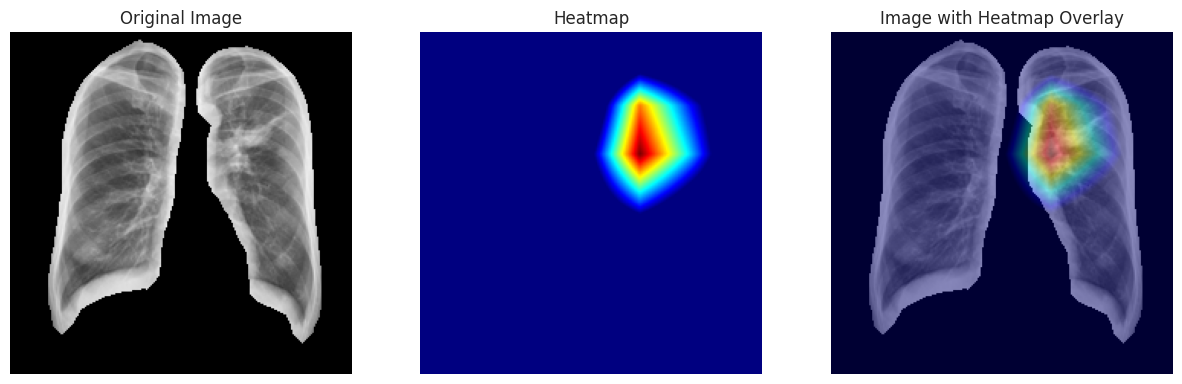

In [71]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.efficientnet import preprocess_input
import numpy as np
import cv2
import matplotlib.pyplot as plt

def make_gradcampp_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape1:
        with tf.GradientTape() as tape2:
            with tf.GradientTape() as tape3:
                last_conv_layer_output, preds = grad_model(img_array)
                if pred_index is None:
                    pred_index = tf.argmax(preds[0])
                class_channel = preds[:, pred_index]

            grads = tape3.gradient(class_channel, last_conv_layer_output)
        grads2 = tape2.gradient(class_channel, last_conv_layer_output)
    grads3 = tape1.gradient(class_channel, last_conv_layer_output)

    alpha_num = grads2**2
    alpha_denom = 2 * grads2**2 + tf.reduce_sum(last_conv_layer_output * grads3, axis=(1, 2))
    alpha_denom = tf.where(alpha_denom != 0, alpha_denom, tf.ones(alpha_denom.shape))
    alphas = alpha_num / alpha_denom
    weights = tf.reduce_sum(alphas * tf.maximum(grads, 0), axis=(1, 2))

    last_conv_layer_output = last_conv_layer_output[0]
    cam = tf.reduce_sum(weights[:, tf.newaxis, tf.newaxis] * last_conv_layer_output, axis=-1)

    heatmap = tf.maximum(cam, 0) / tf.math.reduce_max(cam)
    heatmap = tf.image.resize(heatmap[..., tf.newaxis], (img_array.shape[1], img_array.shape[2]))
    heatmap = tf.squeeze(heatmap)

    return heatmap.numpy()

def display_gradcam(img_path, heatmap, alpha=0.4, threshold_percentile=90):
    # Load and preprocess the original image
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Resize heatmap to match the original image size
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

    # Apply dynamic threshold to the heatmap based on percentile
    threshold_value = np.percentile(heatmap, threshold_percentile)
    heatmap = np.maximum(heatmap - threshold_value, 0)
    heatmap = heatmap / np.max(heatmap)  # Normalize the heatmap

    # Apply colormap to the heatmap
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)  # Convert heatmap to RGB for blending

    # Blend heatmap with the original image
    blended_img = (heatmap * alpha) + (img * (1 - alpha))
    blended_img = np.clip(blended_img, 0, 255).astype(np.uint8)

    # Plotting
    plt.figure(figsize=(15, 5))

    # Plot original image
    plt.subplot(1, 3, 1)
    plt.imshow(img)
    plt.title('Original Image')
    plt.axis('off')

    # Plot heatmap
    plt.subplot(1, 3, 2)
    plt.imshow(heatmap)
    plt.title('Heatmap')
    plt.axis('off')

    # Plot original image with heatmap overlay
    plt.subplot(1, 3, 3)
    plt.imshow(blended_img)
    plt.title('Image with Heatmap Overlay')
    plt.axis('off')

    plt.show()

def get_last_conv_layer_name(model):
    for layer in reversed(model.layers):
        if isinstance(layer, tf.keras.layers.Conv2D):
            return layer.name
    return None

# Example usage
img_path = '/kaggle/working/Image Files/Shenzhen_Custom_Masks/Tuberculosis/CHNCXR_0350_1.png'
#img_path="/content/Shenzhen/Normal/CHNCXR_0010_0.png"
#img_path="/content/Shenzhen/Normal/CHNCXR_0028_0.png"
#img_path="/content/Shenzhen/Tuberculosis/CHNCXR_0327_1.png"
#img_path="/content/Shenzhen/Tuberculosis/CHNCXR_0333_1.png"
#img_path = "/content/Shenzhen/Tuberculosis/CHNCXR_0360_1.png"
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

# Assuming 'base_model' is your model instance
last_conv_layer_name = get_last_conv_layer_name(base_model)
print("Last convolutional layer name:", last_conv_layer_name)

# Create the heatmap
heatmap = make_gradcampp_heatmap(x, base_model, last_conv_layer_name)

display_gradcam(img_path, heatmap)
